In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

seed=42
torch.manual_seed(seed)

### Target
1. Get the setup
2. Set Transforms
3. Set the Data Loader
4. Set the skeleton right
5. Set Training and testing loop
6. Results:



## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [3]:
## Train Phase transformation
train_transforms=transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,),(0.3081,))])

test_transforms=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,),(0.3081,))])

## Get the Dataset and create train and test split


In [4]:
train_set= datasets.MNIST(root="./data",train=True,download=True,transform=train_transforms)

test_set= datasets.MNIST(root="./data",train=False,download=True,transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Data Loader Arguments & Test and Train Arguments

In [5]:
# CUDA?
is_cuda= torch.cuda.is_available()
print("CUDA Available?",is_cuda)

 #for Reproduciability
torch.manual_seed(seed)


if is_cuda:
  torch.cuda.manual_seed(seed)

# Data Loader Arguments - something you will fetch these from Command Prompt 
dataloader_args=dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if is_cuda else dict(shuffle=True,batch_size=64)

# train loader 
train_loader=torch.utils.data.DataLoader(train_set,**dataloader_args)
test_loader= torch.utils.data.DataLoader(test_set,**dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
### Data Statistics
train_data=train_set.transform(train_set.data.cpu().numpy())
print("-Numpy Shape:",train_data.numpy().shape)
print("-Tensor Shape ",train_data.shape)
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

-Numpy Shape: (28, 60000, 28)
-Tensor Shape  torch.Size([28, 60000, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


One batch: torch.Size([128, 1, 28, 28])
Targets of one batch: torch.Size([128])


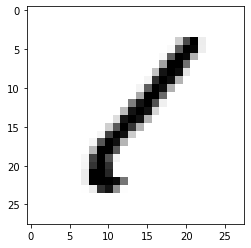

In [7]:
images,labels= next(iter(train_loader))
print("One batch:",images.shape)
print("Targets of one batch:",labels.shape)

plt.imshow(images[0].numpy().squeeze(),cmap="gray_r");

### Illustration of transforms

In [8]:
original_img= images[0]

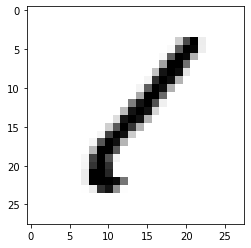

In [9]:
plt.imshow(original_img.squeeze(),cmap="gray_r");

In [10]:
## Create a function to plot the transformed image

def plot(imgs, with_orig=True,row_title=None,**imshow_kwargs):
  if not isinstance(imgs[0],list):
    # make a 2d grid even if there is just 1 row
    imgs=[imgs]
  
  num_rows=len(imgs)
  num_cols= len(imgs[0])+with_orig
  
  fig,axes=plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(12,12),squeeze=False)
  for row_idx,row in enumerate(imgs):    
    row= [original_img]+row if with_orig else row

    for col_idx,img in enumerate(row):     
      ax=axes[row_idx,col_idx]
      ax.imshow(img.squeeze(),** imshow_kwargs)
      ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

  if with_orig:
      axes[0, 0].set(title='Original image')
      axes[0, 0].title.set_size(10)
  if row_title is not None:
      for row_idx in range(num_cols):
          axes[0,row_idx].set(ylabel=row_title[row_idx])

  plt.tight_layout()




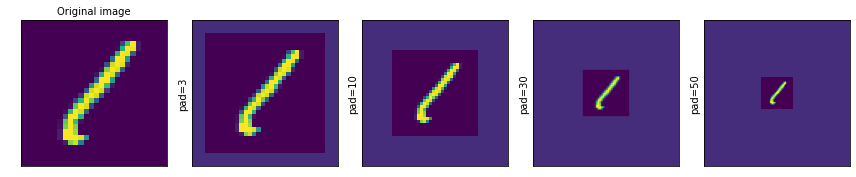

In [11]:
## Pad
padded_imgs= [transforms.Pad(padding=padding)(original_img) for padding in [3,10,30,50]]
plot(padded_imgs,row_title=[" ","pad=3","pad=10","pad=30","pad=50"])

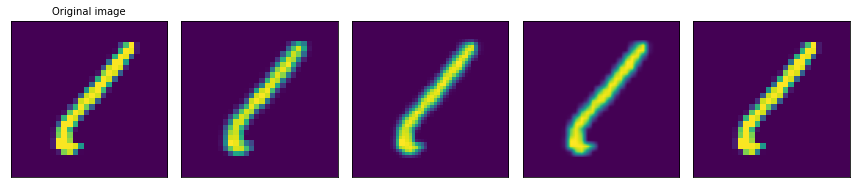

In [12]:
## Resize
resized_img= [transforms.Resize(size=size)(original_img) for size in (30,50,100,original_img.size()[-1])]
plot(resized_img)

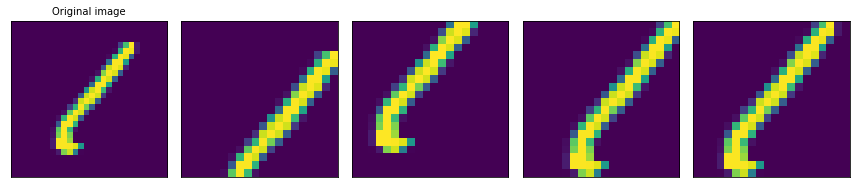

In [13]:
# RandomCrop
random_crop= transforms.RandomCrop(size=(20,20))
crops=[random_crop(original_img) for _ in range(4)]
plot(crops)

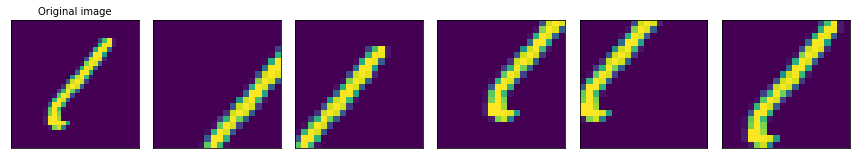

In [14]:
## FiveCrop
(top_left, top_right, bottom_left, bottom_right, center) = transforms.FiveCrop(size=(20, 20))(original_img)
plot([top_left, top_right, bottom_left, bottom_right, center])

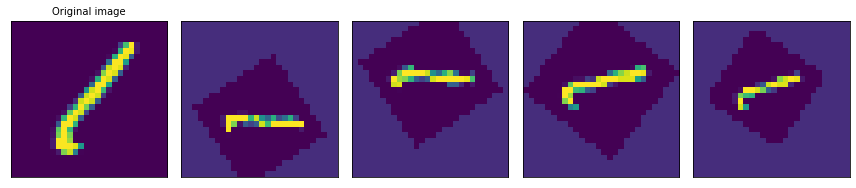

In [15]:
affine_transfomer = transforms.RandomAffine(degrees=(30, 60), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_imgs = [affine_transfomer(original_img) for _ in range(4)]
plot(affine_imgs)

## Random Transformations : RandomPerspective
 means that the same transfomer instance will produce different result each time it transforms a given image.


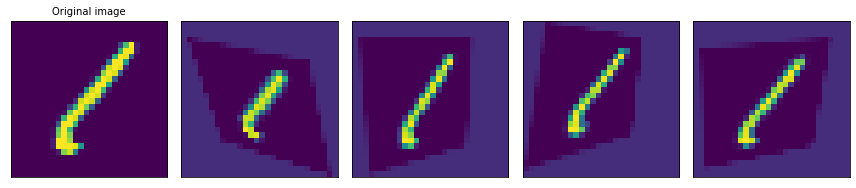

In [16]:
perspective_transformer = transforms.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(original_img) for _ in range(4)]
plot(perspective_imgs)

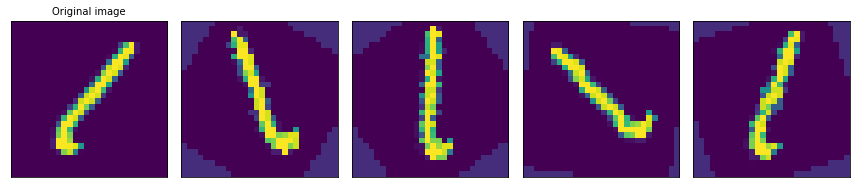

In [17]:
# RandomRotation
rotater = transforms.RandomRotation(degrees=(0, 90))
rotated_imgs = [rotater(original_img) for _ in range(4)]
plot(rotated_imgs)

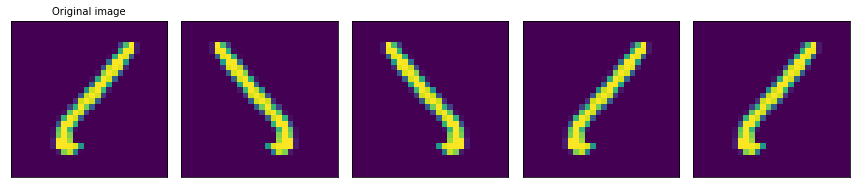

In [18]:
# RandomHorizontalFlip
# Some transforms are randomly-applied given a probability p. That is, the transformed image may actually be the same as the original one, 
# even when called with the same transformer instance!
hflipper = transforms.RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(original_img) for _ in range(4)]
plot(transformed_imgs)

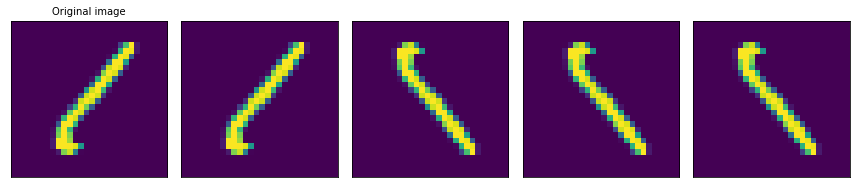

In [19]:
vflipper = transforms.RandomVerticalFlip(p=0.5)
transformed_imgs = [vflipper(original_img) for _ in range(4)]
plot(transformed_imgs)

### Lets get the Data again with some transforms discussed above. We will use this data for training
The PyTorch torchvision library provides us with an MNIST dataset, which downloads the data and provides it in a readily-usable format. Let's use the dataset MNIST function to pull the dataset to our local machine, and then wrap it around a DataLoader. We will use torchvision transformations to convert the data into PyTorch tensors and do data normalization. The following code takes care of downloading, wrapping around the DataLoader and normalizing the data:

**Steps**
1. Initialize transformation
2. Load the data from torchvision dataset
3. Create a dataloader using the data from above step


In [20]:
train_transforms=transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                    #  transforms.RandomVerticalFlip(p=0.5),
                                    #  transforms.RandomHorizontalFlip(p=0.5),
                                    #  transforms.RandomAffine(degrees=(30, 60), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                                    #  transforms.FiveCrop(size=(20, 20)),
                                    #  transforms.Resize(size=20)
                                     ])

test_transforms=transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                    #  transforms.RandomVerticalFlip(p=0.5),
                                    #  transforms.RandomHorizontalFlip(p=0.5),
                                    #  transforms.RandomAffine(degrees=(30, 60), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                                    #  transforms.FiveCrop(size=(20, 20)),
                                    #  transforms.Resize(size=20)
                                     ])                                    

In [21]:
# get train_set
train_set= datasets.MNIST(root="./data",train=True,download=True,transform=train_transforms)
test_set= datasets.MNIST(root="./data",train=False,download=True,transform=test_transforms)

In [22]:
# Create dataLoaders
train_loaders=torch.utils.data.DataLoader(train_set,**dataloader_args)
test_loaders=torch.utils.data.DataLoader(test_set,**dataloader_args)

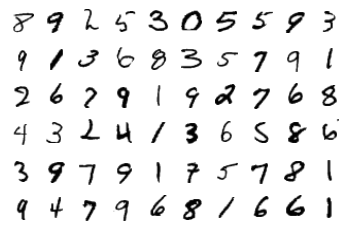

In [23]:
# lets visualize some more images
images,labels= next(iter(train_loader))
num_of_images=60
for index in range(1,num_of_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


## The Model
- Target:
        Add Batch Norm, Regularization, Dropout
- Results:
        Parameters: 8,070
        Best Train Accuracy: 99.22 (20th Epoch) 
        Best Test Accuracy: 99.13
- Analysis:
        Regularization working. 
        But with the current capacity, not possible to push it further. 
        Dropout is not working it seems, but at the same time there is very less difference between training and test accuracy which is desirable. 
        parameters are less than 9k


In [26]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Input Block
    self.convblock1= nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(7,7),padding=0,bias=False),        
        nn.ReLU(),
        nn.BatchNorm2d(10)
        ) # output_size=26 | 3

    # CONVOLUTION BLOCK 1
    self.convblock2= nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10)
    ) # output_size=24 | 5

    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10)
    ) # output_size=22 | 7

    # TRANSITION BLOCK 1
    self.pool1= nn.MaxPool2d(2,2) # output_size=11 | 14
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(20)
    ) # output_size= 11 | 16

    # CONVOLUTION BLOCK 2
    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10)
    ) # output_size=9 | 18
    self.convblock6= nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(20)
    ) # output_size=7 |20

    # OUTPUT BLOCK 
    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10) 
    ) # output_size= 7 | 20
    self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

    self.dropout = nn.Dropout(0.25)

  def forward(self,x):
    x= self.convblock1(x)
    x= self.convblock2(x)
    x= self.convblock3(x)
    x= self.dropout(x)
    x= self.pool1(x)
    x= self.convblock4(x)
    x= self.convblock5(x)
    x= self.convblock6(x)
    x = self.dropout(x)
    x= self.convblock7(x)
    x = self.gap(x)
    x= x.view(-1,10)
    return F.log_softmax(x,dim=-1)



       

## Model Params

In [24]:
# ! pip install torchsummary

In [27]:
from torchsummary import summary
device= torch.device("cuda" if is_cuda else "cpu")
model= Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 22, 22]             490
              ReLU-2           [-1, 10, 22, 22]               0
       BatchNorm2d-3           [-1, 10, 22, 22]              20
            Conv2d-4           [-1, 10, 20, 20]             900
              ReLU-5           [-1, 10, 20, 20]               0
       BatchNorm2d-6           [-1, 10, 20, 20]              20
            Conv2d-7           [-1, 10, 18, 18]             900
              ReLU-8           [-1, 10, 18, 18]               0
       BatchNorm2d-9           [-1, 10, 18, 18]              20
          Dropout-10           [-1, 10, 18, 18]               0
        MaxPool2d-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800
             ReLU-13             [-1, 20, 7, 7]               0
      BatchNorm2d-14             [-1, 2

## Training and Testing
Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [28]:
# training block
from tqdm import tqdm

def train(data_loader,model,optimizer):
    model.train() # set the mode(train/test)
    progress_bar= tqdm(data_loader)
    running_loss=0.0
    running_correct= 0

    # iterate over data- Access batch_id and images and labels
    for batch_idx,(images,target) in enumerate(progress_bar):
      # get samples
      images,target= images.to(device),target.to(device)      
      
      # compute prediction error
      y_pred= model(images)
      loss= F.nll_loss(y_pred,target)
      running_loss+=loss.item() # accumulating loss across every batch
      preds= y_pred.argmax(dim=1,keepdims=True) # get the index of the max log-probability
      running_correct+=preds.eq(target.view_as(preds)).cpu().sum().item()

      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
      # Backpropogation  
      optimizer.zero_grad()          
      loss.backward()
      optimizer.step()     

    # calculate Loss and accuracy accross every epoch
    loss= running_loss/len(data_loader.dataset)
    accuracy=100*(running_correct/len(data_loader.dataset))  

    print(f"Training Loss {loss} Training Accuracy {accuracy:.2f}")    
    return loss, accuracy


In [29]:
def test(data_loader,model,optimizer):
  model.eval()
  progress_bar= tqdm(data_loader)
  running_loss=0.0
  running_correct= 0

  with torch.no_grad():
    for batch_idx,(images,target) in enumerate(progress_bar):
      # get samples
      images,target= images.to(device),target.to(device)

      # prediction
      y_preds= model(images)
      loss=F.nll_loss(y_preds,target)
      running_loss+=loss.item()
      preds= y_preds.argmax(dim=1,keepdims=True) # get the index of the max log-probability
      running_correct+=preds.eq(target.view_as(preds)).cpu().sum().item()

    loss= running_loss/len(data_loader.dataset)
    accuracy=100*(running_correct/len(data_loader.dataset)) 
    print(f"Validation Loss {loss} Validation Accuracy {accuracy:.2f}")
    return loss,accuracy



In [30]:
# model with first filter as 5,5
model=Net().to(device)
optimizer= optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
EPOCHS=20
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,EPOCHS+1):
  print("EPOCH:",epoch)
  epoch_loss, epoch_accuracy= train(train_loader,model,optimizer)
  val_epoch_loss , val_epoch_accuracy = test(test_loader,model,optimizer)
  train_losses.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

EPOCH: 1


100%|██████████| 469/469 [00:13<00:00, 34.75it/s]


Training Loss 0.0025569908741861582 Training Accuracy 93.12


100%|██████████| 79/79 [00:01<00:00, 40.96it/s]


Validation Loss 0.001004446627944708 Validation Accuracy 97.20
EPOCH: 2


100%|██████████| 469/469 [00:11<00:00, 39.57it/s]


Training Loss 0.0007439833094986777 Training Accuracy 97.81


100%|██████████| 79/79 [00:01<00:00, 39.56it/s]


Validation Loss 0.0007059406900778413 Validation Accuracy 97.57
EPOCH: 3


100%|██████████| 469/469 [00:13<00:00, 34.61it/s]


Training Loss 0.0005598871695498626 Training Accuracy 98.27


100%|██████████| 79/79 [00:01<00:00, 39.90it/s]


Validation Loss 0.0006896014155820012 Validation Accuracy 97.44
EPOCH: 4


100%|██████████| 469/469 [00:12<00:00, 38.83it/s]


Training Loss 0.000489660437606896 Training Accuracy 98.40


100%|██████████| 79/79 [00:02<00:00, 38.77it/s]


Validation Loss 0.00048071896508336065 Validation Accuracy 98.16
EPOCH: 5


100%|██████████| 469/469 [00:12<00:00, 38.90it/s]


Training Loss 0.00042398874326609074 Training Accuracy 98.57


100%|██████████| 79/79 [00:01<00:00, 39.58it/s]


Validation Loss 0.0004076389488764107 Validation Accuracy 98.45
EPOCH: 6


100%|██████████| 469/469 [00:11<00:00, 39.36it/s]


Training Loss 0.0003905156700871885 Training Accuracy 98.68


100%|██████████| 79/79 [00:01<00:00, 40.86it/s]


Validation Loss 0.00042227474860846996 Validation Accuracy 98.56
EPOCH: 7


100%|██████████| 469/469 [00:11<00:00, 39.35it/s]


Training Loss 0.0003563531290118893 Training Accuracy 98.79


100%|██████████| 79/79 [00:01<00:00, 40.52it/s]


Validation Loss 0.00038638771162368356 Validation Accuracy 98.64
EPOCH: 8


100%|██████████| 469/469 [00:11<00:00, 39.90it/s]


Training Loss 0.00033994816302632293 Training Accuracy 98.80


100%|██████████| 79/79 [00:01<00:00, 40.69it/s]


Validation Loss 0.0002753587385173887 Validation Accuracy 98.99
EPOCH: 9


100%|██████████| 469/469 [00:11<00:00, 39.62it/s]


Training Loss 0.0003071879479335621 Training Accuracy 98.90


100%|██████████| 79/79 [00:01<00:00, 39.54it/s]


Validation Loss 0.00027506207255646584 Validation Accuracy 99.02
EPOCH: 10


100%|██████████| 469/469 [00:11<00:00, 39.55it/s]


Training Loss 0.0002989938935187335 Training Accuracy 98.94


100%|██████████| 79/79 [00:01<00:00, 41.09it/s]


Validation Loss 0.0002642782036680728 Validation Accuracy 99.07
EPOCH: 11


100%|██████████| 469/469 [00:11<00:00, 40.05it/s]


Training Loss 0.0002877018092976262 Training Accuracy 98.96


100%|██████████| 79/79 [00:01<00:00, 39.74it/s]


Validation Loss 0.0002735607731621712 Validation Accuracy 98.92
EPOCH: 12


100%|██████████| 469/469 [00:11<00:00, 39.70it/s]


Training Loss 0.00027571289422921835 Training Accuracy 99.03


100%|██████████| 79/79 [00:01<00:00, 41.08it/s]


Validation Loss 0.00026440994450822473 Validation Accuracy 98.90
EPOCH: 13


100%|██████████| 469/469 [00:12<00:00, 36.14it/s]


Training Loss 0.0002587820181118635 Training Accuracy 99.10


100%|██████████| 79/79 [00:02<00:00, 38.98it/s]


Validation Loss 0.00026281640550587326 Validation Accuracy 99.02
EPOCH: 14


100%|██████████| 469/469 [00:12<00:00, 38.92it/s]


Training Loss 0.00025603108808475855 Training Accuracy 99.11


100%|██████████| 79/79 [00:01<00:00, 40.40it/s]


Validation Loss 0.00027465949405450376 Validation Accuracy 98.95
EPOCH: 15


100%|██████████| 469/469 [00:11<00:00, 39.57it/s]


Training Loss 0.00023794148511175687 Training Accuracy 99.15


100%|██████████| 79/79 [00:01<00:00, 40.49it/s]


Validation Loss 0.00026847803653217854 Validation Accuracy 98.98
EPOCH: 16


100%|██████████| 469/469 [00:11<00:00, 39.37it/s]


Training Loss 0.0002209649390152966 Training Accuracy 99.22


100%|██████████| 79/79 [00:01<00:00, 39.98it/s]


Validation Loss 0.00023893924155272544 Validation Accuracy 99.10
EPOCH: 17


100%|██████████| 469/469 [00:11<00:00, 39.73it/s]


Training Loss 0.00022573449772316962 Training Accuracy 99.20


100%|██████████| 79/79 [00:01<00:00, 39.61it/s]


Validation Loss 0.00025267989120911807 Validation Accuracy 99.07
EPOCH: 18


100%|██████████| 469/469 [00:11<00:00, 39.42it/s]


Training Loss 0.000210026759650403 Training Accuracy 99.26


100%|██████████| 79/79 [00:01<00:00, 40.70it/s]


Validation Loss 0.0003007292190100998 Validation Accuracy 98.87
EPOCH: 19


100%|██████████| 469/469 [00:11<00:00, 40.18it/s]


Training Loss 0.0002207697461708449 Training Accuracy 99.23


100%|██████████| 79/79 [00:01<00:00, 39.91it/s]


Validation Loss 0.0002007424717419781 Validation Accuracy 99.24
EPOCH: 20


100%|██████████| 469/469 [00:11<00:00, 39.34it/s]


Training Loss 0.00021094922186651576 Training Accuracy 99.22


100%|██████████| 79/79 [00:01<00:00, 40.18it/s]

Validation Loss 0.000239652320696041 Validation Accuracy 99.13


In [ ]:

## Plot the logs
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(8,8))
sns.lineplot(y=train_accuracy,x=range(len(train_accuracy)),label="Training Accuracy")
sns.lineplot(y=val_accuracy,x=range(len(val_accuracy)),label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
sns.lineplot(y=train_losses,x=range(len(train_losses)),label="Training Loss")
sns.lineplot(y=val_losses,x=range(len(val_losses)),label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()